In [3]:
import os
import json
import random
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 데이터 import  
- 데이터 import부터 모델 학습까지의 코드는 실험을 위해 팀원들과 같은 코드로 진행하였음
- 비교할 대상을 제외한 나머지 조건을 통일시킴

In [5]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

## 모델 준비

In [6]:
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [7]:
def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

In [10]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=2
    )
    ds = ds.map(
        onehot,
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [11]:
def history_conv(history):
    
    return_history = {'loss' : list(history['loss'].values()),
                      'accuracy' : list(history['accuracy'].values()),
                      'val_loss' : list(history['val_loss'].values()),
                      'val_accuracy' : list(history['val_accuracy'].values())}
    
    return return_history

## 데이터 준비

In [12]:
BATCH_SIZE = 16

In [13]:
num_classes = ds_info.features["label"].num_classes

In [14]:
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)

In [15]:
ds_test_all = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE, is_test=True)

## 모델 생성

In [16]:
def build_model(num_classes):
    base_model = keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg')
    
    output = base_model.output
    
    output = keras.layers.Dense(num_classes, activation='softmax', use_bias=False)(output)
    model = keras.Model(inputs=base_model.input, outputs=output)
    return model

In [17]:
cam_model = build_model(num_classes)

In [18]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

## 모델 훈련

In [19]:
EPOCH = 50

In [20]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(os.getenv('HOME')+'/aiffel/Deep_Dive(CV)_RS10/9_Class_Activation_Map/history/cam_model_resnet50_best_val_loss.h5', verbose=1, save_best_only=True, mode='min', save_weights_only=True)

In [21]:
cam_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_resnet50_cam = cam_model.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test_all,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[checkpoint]
)

Epoch 1/50
750/750 [==============================] - 201s 198ms/step - loss: 2.2170 - accuracy: 0.4482 - val_loss: 3.1214 - val_accuracy: 0.2442

Epoch 00001: val_loss improved from inf to 3.12137, saving model to /aiffel/aiffel/Deep_Dive(CV)_RS10/9_Class_Activation_Map/history/cam_model_resnet50_best_val_loss.h5
Epoch 2/50
750/750 [==============================] - 149s 199ms/step - loss: 0.7998 - accuracy: 0.7776 - val_loss: 1.2510 - val_accuracy: 0.6409

Epoch 00002: val_loss improved from 3.12137 to 1.25103, saving model to /aiffel/aiffel/Deep_Dive(CV)_RS10/9_Class_Activation_Map/history/cam_model_resnet50_best_val_loss.h5
Epoch 3/50
750/750 [==============================] - 165s 220ms/step - loss: 0.2513 - accuracy: 0.9448 - val_loss: 0.9629 - val_accuracy: 0.7160

Epoch 00003: val_loss improved from 1.25103 to 0.96290, saving model to /aiffel/aiffel/Deep_Dive(CV)_RS10/9_Class_Activation_Map/history/cam_model_resnet50_best_val_loss.h5
Epoch 4/50
750/750 [========================

In [22]:
cam_model.save_weights(os.getenv('HOME')+'/aiffel/Deep_Dive(CV)_RS10/9_Class_Activation_Map/history/cam_model_resnet50_last.h5')

In [23]:
cam_model.save(os.getenv('HOME')+'/aiffel/Deep_Dive(CV)_RS10/9_Class_Activation_Map/history/cam_model_resnet50.keras')

/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [24]:
with open('history/history_resnet50.json', 'w') as f:
    pd.DataFrame(history_resnet50_cam.history).to_json(f)

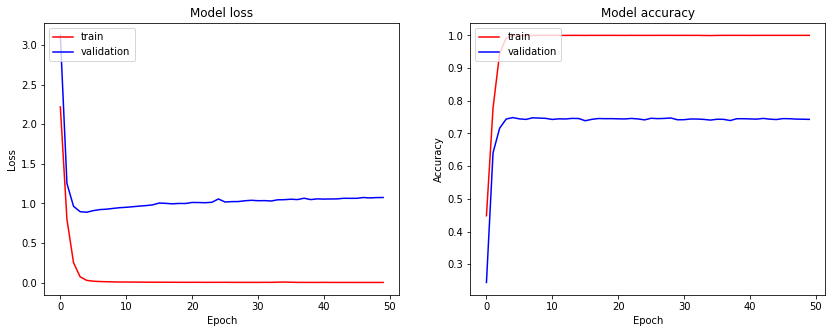

In [26]:
plt.figure(figsize=(14, 5))

plt.subplot(121)
plt.plot(history_resnet50_cam.history['loss'], 'r')
plt.plot(history_resnet50_cam.history['val_loss'], 'b')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.subplot(122)
plt.plot(history_resnet50_cam.history['accuracy'], 'r')
plt.plot(history_resnet50_cam.history['val_accuracy'], 'b')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## 목표 : 이론을 참고하여 직접 CAM 코드 구현하기

### CAM  

- Image Classification에서 사용
- 모델이 클래스를 유추하기 위해 어느 부분을 중점적으로 보는지 시각화하는 방법
- 특정 구조의 모델에서만 사용 가능
- Full Connected layer 가중치를 사용
- GAP를 사용  


**CAM 수식**
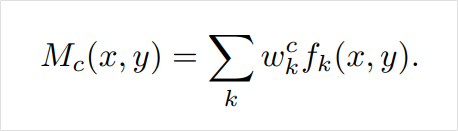

1. fk : 특정 채널 k의 특징 맵
2. FK : 특징 맵 fk를 GAP로 활성화 역할
3. wck : 클래스 c에 대한 특징 맵 fk의 가중치
4. Sc : 각 위치(x,y)에서의 특징 맵 fk와 가중치 wck를 곱하여 합친 값   
=> 클래스 c에 대한 예측 점수
5. Mc : 각 특징맵 fk와 가중치 wck를 곱하여 합친 값  

### Grad-CAM

- CAM의 확장버전
- 모든 CNN 모델에도 적용 가능
- 가중치 대신 기울기 사용
    - 기울기 사용하는 이유 : FC 가중치만으로는 특정 Feature Map의 동적 중요성을 반영하기 어려움.  
    현재 Feature Map의 변화량을 나타내므로 레이어별 해석이 쉬움
- 역전파를 통해 동적으로 주목 영역 계산


**Grad-CAM 수식**
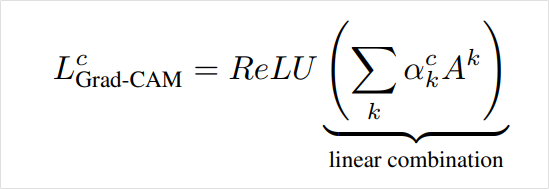

1. Ak : 클래스 c에 대한 각 특징 맵 k
2. ∝ck : 클래스 c에 대한 특징 맵 k의 기울기를 평균한 가중치
3. Lc : 각 특징 맵 Ak에 가중치 ∝ck를 곱해 더한 후 ReLU 적용

### CAM, Grad-CAM 관련 강의 링크  


**실행 순서**  
참조링크(https://www.youtube.com/watch?v=rRiygGHjkOQ)


### CAM
1. convolution layer 뒤에 GAP를 사용하여 특징 맵의 평균을 구한 뒤, 채널 당 하나의 값으로 요약 (채널 = 특징 맵 커널의 채널)
2. 이 채널 당 하나로 요약한 값을  input, 클래스를 output으로 가지고 학습 진행(클래스마다 해당 가중치가 달라짐)
3. 이 학습을 통해 얻은 weight를 다시 평균 구하기 전의 특징 맵에 곱해 준다.
4. 가중치가 적용된 각 특징 맵이 나옴. 이것을 동일 위치 픽셀별 합을 더함.  
    이것을 히트맵으로 표현하면 값이 큰 곳이 더 밝아진다.  
    그럼 해당 클래스의 예측 원인을 히트맵으로 판단할 수 있다.  
    그 히트맵이 곧 class activation map
    
    
### Grad-CAM
1. GAP와 가중치 사용 X. 대신 기울기를 구해야 한다.
2. 기울기 구하는 법 : feature map의 각 원소가 특정 클래스에 주는 영향력을 gradient를 통해서 구한다.  
    = c의 출력값을 특징 맵의 원소로 미분해준다.  
    = 핵심은 feature map 의 하나하나의 값이 output에 어떤 영향을 주는 지 계산하기 위해서 gradient 개념을 사용하는 것!  
3. 각 원소의 기울기를 구한 뒤 평균을 구한다.  
    채널 당 하나의 특징 맵를 가지고 있으므로 채널 개수만큼의 기울기를 구한다.  
    구한 기울기를 모두 더해준다

# 데이터셋 설정

### 변경사항
지도학습 데이터로 변경,  
원핫 인코딩 함수 추가

In [6]:
# cam 구현 전의 코드 재실행
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
#     as_supervised=True,            #지도학습 추가
    shuffle_files=True,
    with_info=True,
)

# 데이터 전처리 함수

def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

# # 원핫 인코딩 추가
# def onehot(image, label):
#     label = tf.one_hot(label, num_classes)
#     return image, label

# def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
#     ds = ds.map(
#         normalize_and_resize_img, 
#         num_parallel_calls=2
#     )
#     ds = ds.map(
#         onehot,
#         num_parallel_calls=2
#     )
#     ds = ds.batch(batch_size)
    
#     if not is_test:
#         ds = ds.repeat()
#         ds = ds.shuffle(200)

#     ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
#     return ds

**주의할 점**  
as_supervised=False => 데이터 형식이 딕셔너리  
as_supervised=True => 데이터 형식이 튜플 + **bbox 정보 제거됨**  

이니 형식 바꿀 때 주의해야 함!  

이유 : as_supervised=True는 분류 문제에 맞는 형식으로 데이터를 제공하기 때문    
이미 as_supervised=True로 학습했기 떄문에 bbox 잘 맞지 않을 수 있으니 감안해야 함...

In [7]:
# feature 구성 확인
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

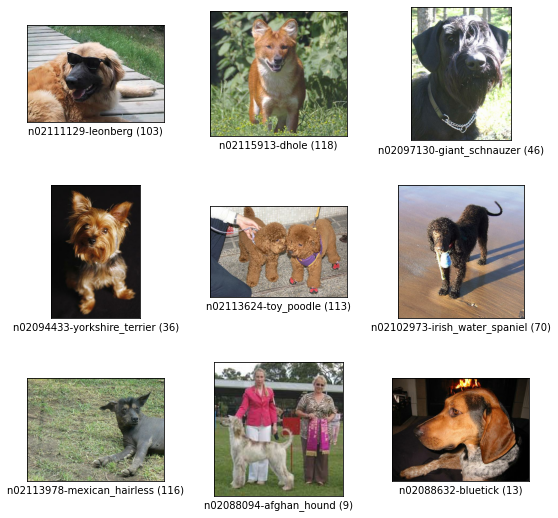

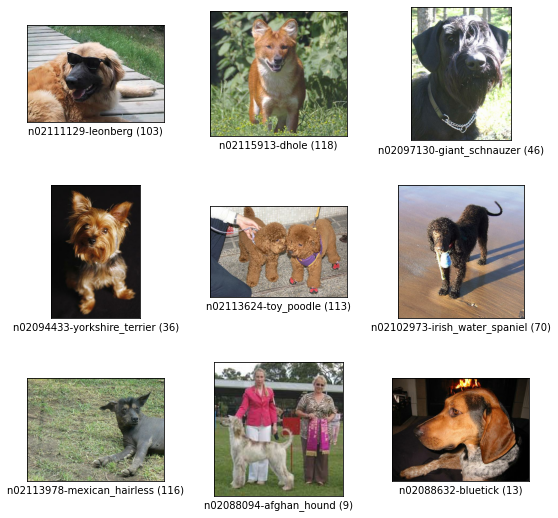

In [8]:
tfds.show_examples(ds_train, ds_info)

In [9]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

11


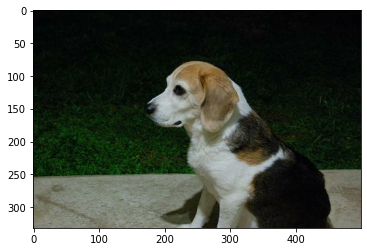

In [127]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [128]:
# 모델 불러오기

import os
cam_model_path = os.getenv('HOME')+'/aiffel/Deep_Dive(CV)_RS10/9_Class_Activation_Map/history/cam_model_resnet50.keras'
cam_model = tf.keras.models.load_model(cam_model_path)

# 최적 가중치 불러오기
cam_model_weight_path = os.getenv('HOME') + '/aiffel/Deep_Dive(CV)_RS10/9_Class_Activation_Map/history/cam_model_resnet50_best_val_loss.h5'
cam_model.load_weights(cam_model_weight_path)

## CAM 구현하기

In [129]:
def generate_cam(model, item):
    # 1. 이미지 데이터 가져오기
    item = copy.deepcopy(item)     # item 객체 resize 방지
    # resizing 전 item의 크기 저장
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    # 2. 이미지 전처리
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 배치 단위로 만들어주기 (1, 224, 224, 3)
    img_tensor = tf.expand_dims(img_tensor, axis=0)

    # 3. Feature Map 및 FC 레이어 처리
    feature_map_layer = model.layers[-3].output  # 마지막 convolutional layer
    fc_weights = model.layers[-1].get_weights()[0]  # Dense 레이어의 가중치

    # 4. Feature Map 추출
    feature_map_model = tf.keras.models.Model(inputs=model.input, outputs=feature_map_layer)
    feature_map = feature_map_model.predict(img_tensor) # 배치 단위로 예측

    # 5. CAM 계산
    feature_map = feature_map[0]   # cam_image 크기를 위해 하나의 특징 맵 추출
    cam_image = np.zeros(dtype=np.float32, shape=feature_map.shape[0:2])  # CAM 이미지 초기화

    # 6. 각 feature map과 weight를 곱하여 합산
    for i, w in enumerate(fc_weights[:, class_idx]):  # class_idx에 해당하는 weight만 사용
        cam_image += w * feature_map[:, :, i]  # 각 채널의 feature map에 가중치를 곱해서 더함
    
    cam_image /= np.max(cam_image)  # 최대값으로 정규화
    cam_image = np.maximum(cam_image, 0)  # 음수 제거
    cam_image = cv2.resize(cam_image, (width, height))  # 원본 이미지 크기로 리사이즈

    return cam_image


tem 객체는 Python에서 mutable(변경 가능한) 타입이기 때문에, 함수 내에서 item을 변경하면 그 변경사항이 함수 외부에도 영향을 미칩니다. 그러나, 만약 item을 copy.deepcopy(item)으로 복사한 후 사용했다면, 함수 내부에서의 변경사항은 외부의 원본 item에는 영향을 미치지 않습니다.

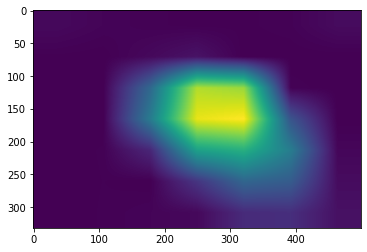

In [130]:
# CAM 이미지 생성
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [131]:
# 원본 이미지와 CAM 이미지 합성

def visualize_cam_on_image(image, cam_image):
    merged_image = None

    # 원본 이미지와 히트맵 합성
    merged_image = cv2.addWeighted(image, 0.6, cam_image, 0.4, 0)
        
    return merged_image

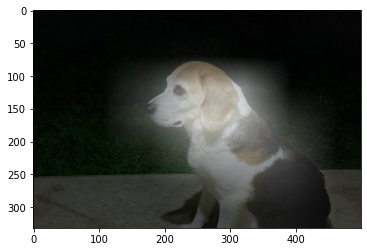

In [132]:
# visualize_cam_on_image() 함수 사용

origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

## Grad-CAM 구현하기

100


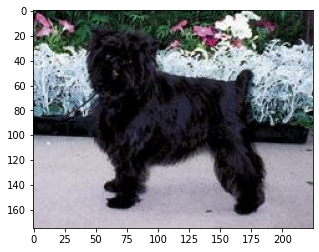

In [133]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

1. GAP를 사용하지 않고 대신 기울기를 구해야 한다.
2. 기울기 구하는 법 : feature map의 각 원소가 특정 클래스에 주는 영향력을 gradient를 통해서 구한다.  
    = c의 출력값을 특징 맵의 원소로 미분해준다.  
    = 핵심은 feature map 의 하나하나의 값이 output에 어떤 영향을 주는 지 계산하기 위해서 gradient 개념을 사용하는 것!  
3. 각 원소의 기울기를 구한 뒤 평균 시켜준다.  
    채널 당 하나의 특징 맵를 가지고 있으므로 채널 개수만큼의 기울기를 구한다. 구한 기울기를 모두 더해준다

In [134]:
# 모델 불러오기

import os
grad_cam_model = tf.keras.models.load_model(cam_model_path)

# 최적 가중치 불러오기
grad_cam_model.load_weights(cam_model_weight_path)

In [138]:
def generate_grad_cam(model, activation_layer, item):
    grad_cam_image = None
    # 1. 이미지 데이터 가져오기
    item = copy.deepcopy(item)     # item 객체 resize 방지
    # resizing 전 item의 크기 저장
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    # 2. 이미지 전처리
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 3. activation_layer 레이어 추출
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])    
    
    # 4. 기울기 계산 (GradientTape 사용)

    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0)) # feature map과 예측값 출력
    
        loss = pred[:, class_idx] # gradient 계산에 필요
        output = conv_output[0] # feature map의 배치 추출
        grad = tape.gradient(loss, conv_output)[0] # 예측값이 변화할 때의 레이어 출력의 변화량 구하기
    
    # 6. 각 feature map과 기울기를 곱하여 합산
    weights = np.mean(grad, axis=(0, 1)) # gradient 모두 더한 뒤 평균 구하기
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        grad_cam_image += w * output[:, :, k] # 각 채널의 feature map에 가중치를 곱해서 더함
    
    grad_cam_image = tf.math.maximum(0, grad_cam_image)   # Relu 활성화
    grad_cam_image /= np.max(grad_cam_image)              # 정규화
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    
    return grad_cam_image

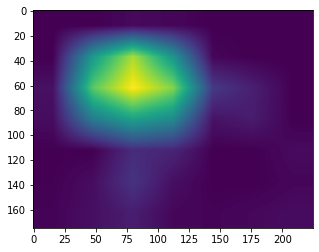

In [139]:
# Grad-CAM 이미지 생성
grad_cam_image = generate_grad_cam(grad_cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)

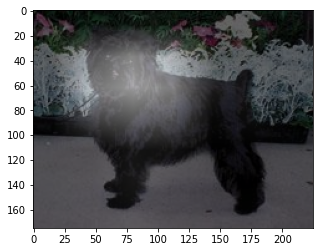

In [141]:
# visualize_cam_on_image() 함수 사용

origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

## bounding box 만들기

In [144]:
# bounding box 만들기

def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [177]:
# bounding box 좌표 확인

rect = get_bbox(grad_cam_image)
rect

array([[226, 374],
       [226, 321],
       [261, 321],
       [261, 374]])

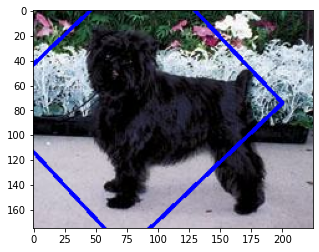

In [146]:
# bounding box 시각화


image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

## IoU 계산하기

In [147]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [148]:
# minmax 형태로 치환하기
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[-0.24, -0.15555555555555556, 1.1028571428571428, 0.8888888888888888]

In [149]:
item['objects']['bbox']

array([[0.08      , 0.16444445, 0.94857144, 0.84      ]], dtype=float32)

In [150]:
# IoU 계산하기

def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [151]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.41836126053586925

## CAM vs Grad-CAM 비교하기

100


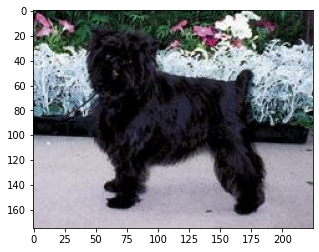

In [196]:
# 이미지 선택
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

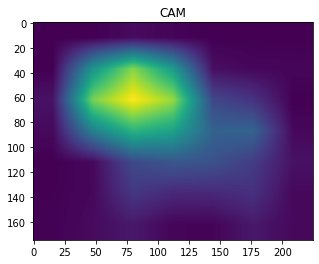

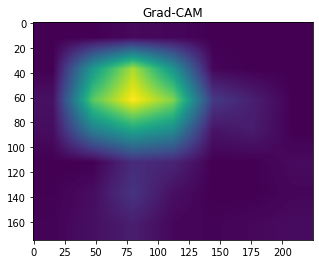

In [197]:
# cam_image 비교

cam_image = generate_cam(cam_model, item)
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)

plt.imshow(cam_image)
plt.title("CAM")
plt.show()

plt.imshow(grad_cam_image)
plt.title("Grad-CAM")
plt.show()

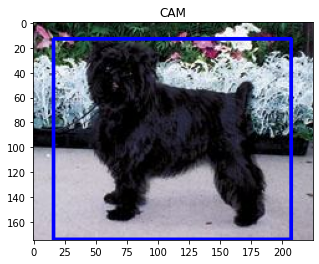

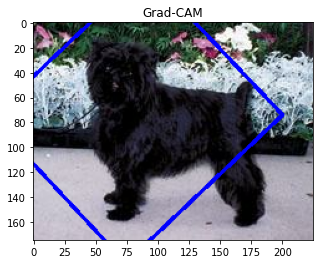

In [199]:
# bounding box 비교

rect_cam = get_bbox(cam_image)
rect_grad = get_bbox(grad_cam_image)

image1 = copy.deepcopy(item['image'])
image2 = copy.deepcopy(item['image'])


image_cam = cv2.drawContours(image1, [rect_cam], 0, (0,0,255), 2)
image_grad = cv2.drawContours(image2, [rect_grad], 0, (0,0,255), 2)

plt.imshow(image_cam)
plt.title("CAM")
plt.show()

plt.imshow(image_grad)
plt.title("Grad-CAM")
plt.show()

같은 이미지이지만 grad-cam의 경우 뒷발까지 잡아내지 않음  
-> CAM의 활성화 범위가 전반적으로 크다고 생각함

In [200]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [201]:
# IoU 비교

# minmax 형태로 치환하기
pred_bbox_cam = rect_to_minmax(rect_cam, item['image'])
pred_bbox_grad = rect_to_minmax(rect_grad, item['image'])

cam_iou = get_iou(pred_bbox_cam, item['objects']['bbox'][0])
grad_iou = get_iou(pred_bbox_grad, item['objects']['bbox'][0])

print(f'cam iou : {cam_iou}\ngrad iou : {grad_iou}')

cam iou : 0.7513251800947409
grad iou : 0.41836126053586925


Grad-CAM의 경우가 IoU가 더 낮은 결과를 보인다

### 회고

generate cam 함수를 직접 구현하려고 하니 전혀 갈피를 잡지 못하겠어서 다시 처음부터 공부를 해야 했다.
공부 후 체계를 이해했다고 생각해도 그걸 코드로 구현하는 과정에서 다시 어려움을 겪고 결국 기존 코드를 참고하여 겨우 완성했다.
이런 시행착오를 겪으면서 예상치 못한 (tfds 옵션에 따라 데이터셋의 타입이 달라진다) 새로운 사실을 알게 되었다.  

CAM, Grad-CAM 구현하느라 뒤의 bounding box나, iou는 직접 구현하지 못하고 코드를 보며 이해하는 정도에 그쳐서 개념에 대해 다시 살펴봐야겠다.  

팀원들과 추가 실험을 위해서 여러가지 모델을 준비해보았지만 막상 프로젝트 구현 시간이 부족하여 비교까지 실행하지 못한 게 아쉽다. 수업을 마치고 시간이 있다면 꼭 비교 실험을 해봐야겠다!